In [1]:
!pip install -q yfinance
!pip install pmdarima
!pip install statsmodels --upgrade

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# For time stamps
from datetime import datetime
import math
from sklearn.metrics import mean_squared_error

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras import callbacks

# For ARIMA model
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# DATA IMPORT

In [3]:
tech_list = ['CIBEY']

end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


# 1. What was the change in price of the stock overtime?

In [4]:
company_list = [CIBEY]
company_name = ["Commercial International Bank (Egypt)"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-10-27,1.090,1.11,1.08,1.09,1.09,111300,Commercial International Bank (Egypt)
2023-10-30,1.090,1.12,1.09,1.11,1.11,73500,Commercial International Bank (Egypt)
2023-10-31,1.090,1.14,1.09,1.10,1.10,62600,Commercial International Bank (Egypt)
2023-11-01,1.070,1.12,1.07,1.12,1.12,95100,Commercial International Bank (Egypt)
2023-11-02,1.100,1.15,1.09,1.09,1.09,44200,Commercial International Bank (Egypt)
2023-11-03,1.150,1.15,1.12,1.12,1.12,51400,Commercial International Bank (Egypt)
2023-11-06,1.190,1.19,1.12,1.17,1.17,96900,Commercial International Bank (Egypt)
2023-11-07,1.160,1.22,1.16,1.22,1.22,41900,Commercial International Bank (Egypt)
2023-11-08,1.240,1.26,1.21,1.23,1.23,38900,Commercial International Bank (Egypt)


In [5]:
ts=df['Close']

In [6]:
CIBEY.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,2.193605,2.238693,2.156957,2.194379,2.090612,1.226035e+05
std,0.727232,0.735505,0.722892,0.728943,0.655202,2.046840e+05
min,0.997340,1.070000,0.997340,1.060000,1.049701,5.866000e+03
25%,1.340000,1.390000,1.300000,1.332500,1.330000,4.243475e+04
50%,2.416888,2.466755,2.367021,2.420213,2.296839,7.053800e+04
75%,2.726064,2.785904,2.679521,2.726064,2.568458,1.278025e+05
max,3.623670,3.663564,3.597074,3.650266,3.401183,2.852787e+06


In [7]:
CIBEY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-11-09 to 2023-11-09
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1258 non-null   float64
 1   High          1258 non-null   float64
 2   Low           1258 non-null   float64
 3   Close         1258 non-null   float64
 4   Adj Close     1258 non-null   float64
 5   Volume        1258 non-null   int64  
 6   company_name  1258 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 78.6+ KB


<Axes: xlabel='Date'>

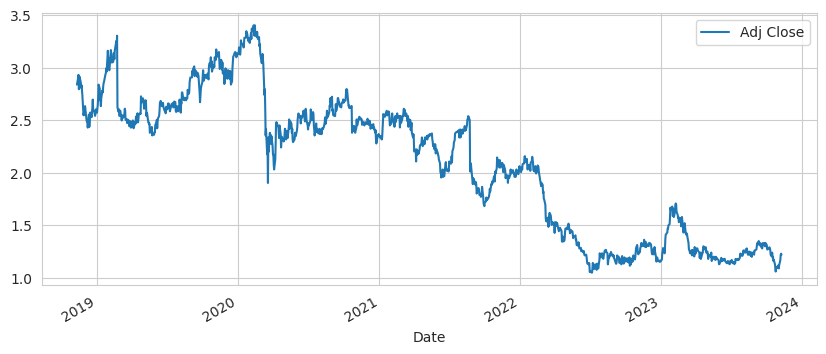

In [8]:
# Plotting Adjusted Closing price for CIB Stock

CIBEY['Adj Close'].plot(legend=True,figsize=(10,4))

<Axes: xlabel='Date'>

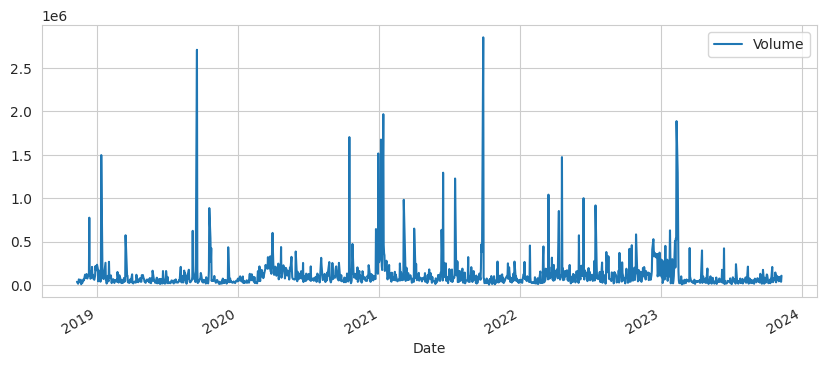

In [9]:
# Plotting the total volume of stock being traded each day

CIBEY['Volume'].plot(legend=True,figsize=(10,4))

# 2. What was the moving average of the various stocks?

In [10]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

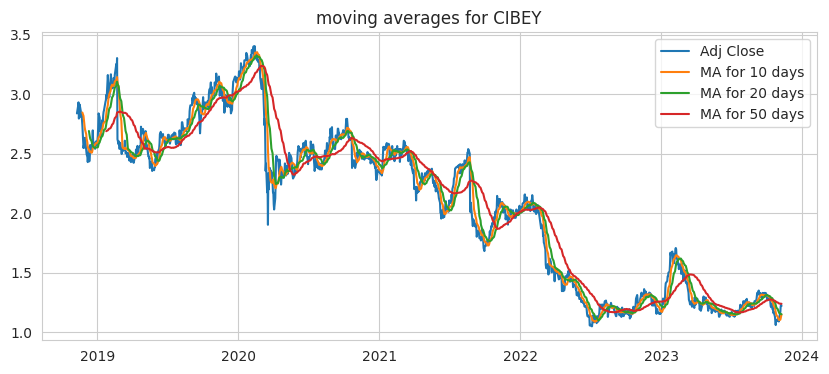

In [11]:
# Plotting the moving averages

plt.figure(figsize=(10,4))
plt.title('moving averages for CIBEY')
plt.plot(CIBEY[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']])
plt.legend(['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'])
plt.show()

In [12]:
print(CIBEY.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')


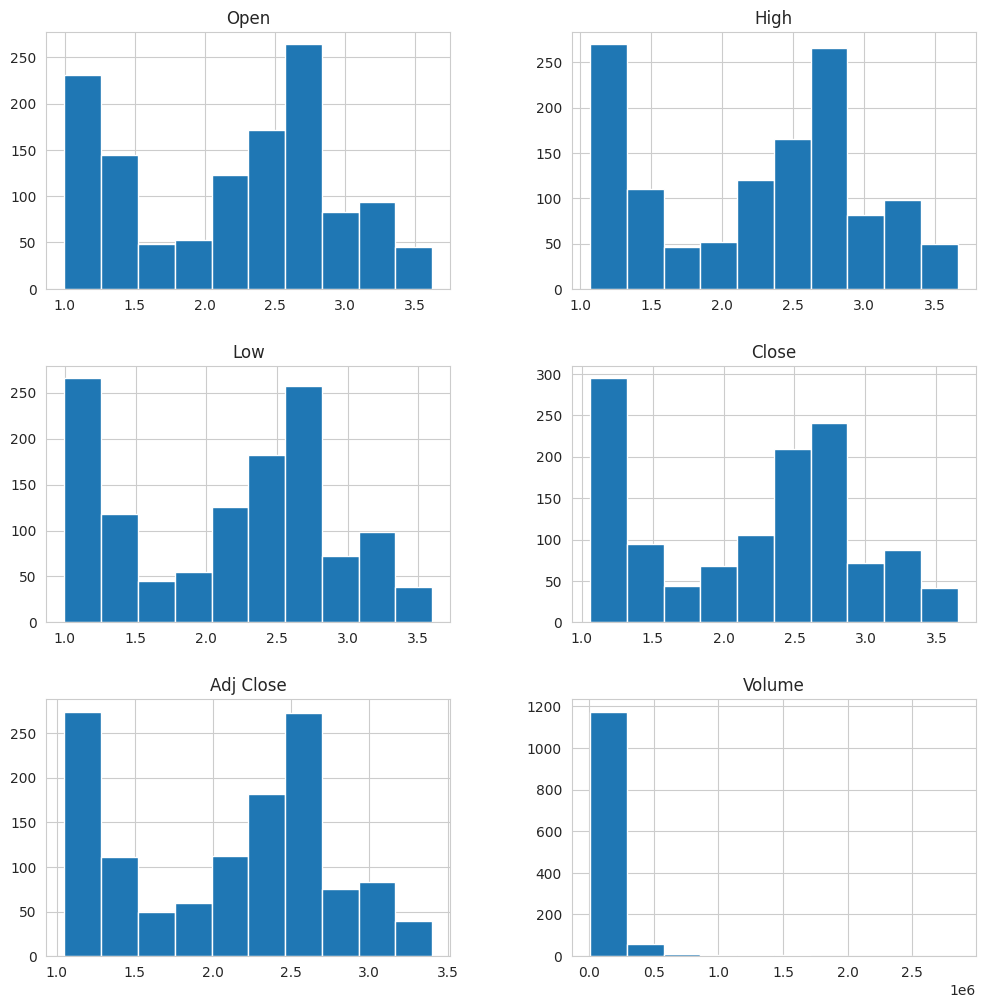

In [13]:
df.groupby("company_name").hist(figsize=(12, 12));

# 3. What was the daily return of the stock on average?

<Axes: xlabel='Date'>

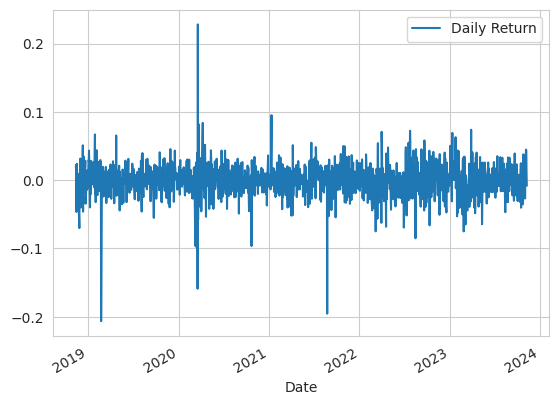

In [14]:
# Plotting Daily returns as a function of Percent change in Adjusted Close value

CIBEY['Daily Return'] = CIBEY['Adj Close'].pct_change()

CIBEY['Daily Return'].plot(legend=True)

<Axes: xlabel='Daily Return', ylabel='Density'>

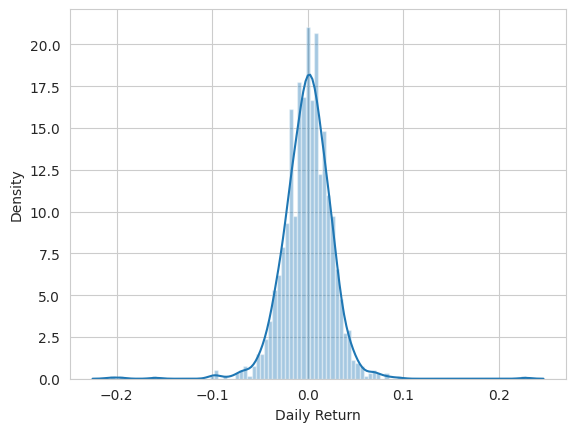

In [15]:
# Plotting the average daily returns of the stock

sns.distplot(CIBEY['Daily Return'].dropna(),bins=100)

# 4. How much value do we put at risk by investing in a particular stock?

Text(0, 0.5, 'Risk')

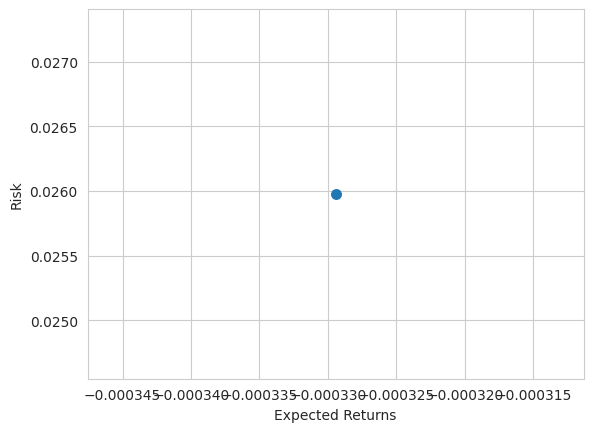

In [16]:
# Risk Analysis --  Comparing the Risk vs Expected returns

rets = CIBEY['Daily Return'].dropna()

area = np.pi*15

plt.scatter(rets.mean(),rets.std(),s=area)
[]
plt.xlabel('Expected Returns')
plt.ylabel('Risk')

<Axes: xlabel='Daily Return', ylabel='Density'>

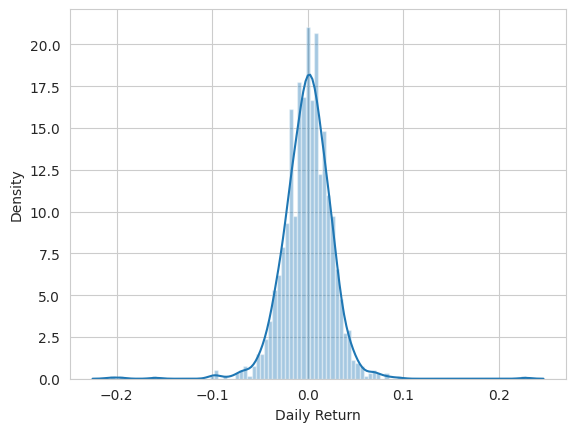

In [17]:
# Visualizing the Value at Risk

sns.distplot(CIBEY['Daily Return'].dropna(),bins=100)

In [18]:
# Using Quantiles and the Bootstrap Method to calculate the numerical risk of the stock

CIBEY['Daily Return'].quantile(0.05)

-0.038889187242283185

In [19]:
## Monte Carlo Simulation

days = 365

dt = 1/days

mu = rets.mean()

sigma = rets.std()

In [20]:
# Defining the Monte Carlo Simulation Function

def stock_monte_carlo(start_price,days,mu,sigma):

    price = np.zeros(days)
    price[0] = start_price

    shock = np.zeros(days)
    drift = np.zeros(days)

    for x in range(1,days):
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))

        drift[x] = mu * dt

        price[x] = price[x-1] + (price[x-1]* (drift[x] + shock[x]))

    return price

In [21]:
CIBEY.head()

,Open,High,Low,Close,Adj Close,Volume,company_name,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
Date,,,,,,,,,,,
2018-11-09,2.992021,3.078457,2.925532,3.045213,2.837417,38502,Commercial International Bank (Egypt),NaN,NaN,NaN,NaN
2018-11-12,2.998670,3.111702,2.998670,3.111702,2.899369,16243,Commercial International Bank (Egypt),NaN,NaN,NaN,0.021834
2018-11-13,3.025266,3.158245,3.025266,3.144947,2.930345,31584,Commercial International Bank (Egypt),NaN,NaN,NaN,0.010684
2018-11-14,3.058511,3.218085,2.985372,2.998670,2.794050,66627,Commercial International Bank (Egypt),NaN,NaN,NaN,-0.046512
2018-11-15,2.972074,3.151596,2.972074,3.051862,2.843612,50083,Commercial International Bank (Egypt),NaN,NaN,NaN,0.017739


Text(0.5, 1.0, 'Monte Carlo Simulation for CIB')

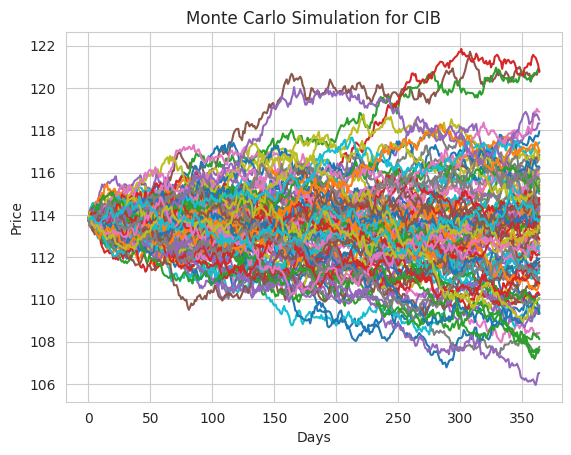

In [22]:
# Running the Monte Carlo simulation a hundred times

start_price = 113.790001

for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Simulation for CIB')

In [23]:
# Analysing the Monte Carlo Simulation for 10,000 simulations

runs = 10000

simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]

# 1 percent impirical quantile or 99% Confidence Interval

q = np.percentile(simulations,1)

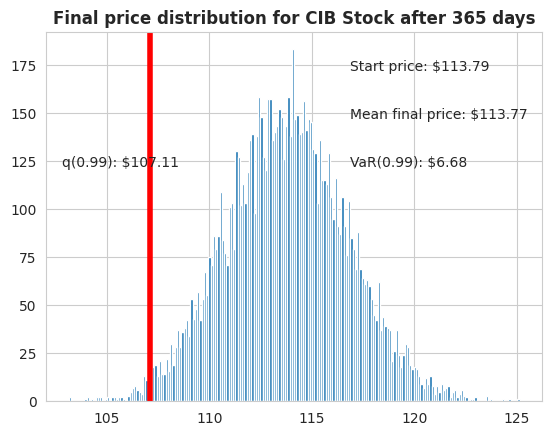

In [24]:
# Plotting the final Risk Analysis plot using Monte Carlo Simulation

plt.hist(simulations,bins=200)

plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for CIB Stock after %s days" % days, weight='bold');

<Axes: ylabel='Density'>

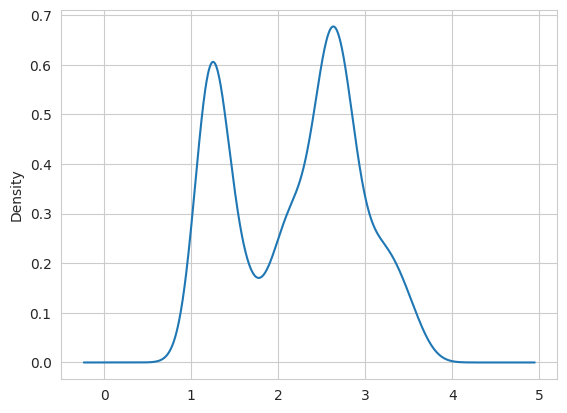

In [25]:
#Distribution of the dataset
ts.plot(kind='kde')

# Prediction Models

In [26]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

1007

In [27]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.76641281],
       [0.7920816 ],
       [0.80491622],
       ...,
       [0.06176975],
       [0.06563035],
       [0.06176975]])

In [28]:
# Create the training data set
sequence_length = 10  # Number of previous time steps to consider
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i])
    y_train.append(train_data[i])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create the testing data set
test_data = scaled_data[training_data_len - sequence_length:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = scaled_data[training_data_len:, :]
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# LSTM model

In [76]:
from tensorflow.keras.callbacks import EarlyStopping
# Build the LSTM model
tf.random.set_seed(51)
model = Sequential()
model.add(LSTM(256, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=3, restore_best_weights=True)


# Train the model
model.fit(x_train,y_train,epochs=100,batch_size=40,shuffle=False, callbacks =[early_stopping])
model.summary()

Epoch 1/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0770 - accuracy: 0.0022

25/25 [==============================] - 4s 8ms/step - loss: 0.0713 - accuracy: 0.0020
Epoch 2/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0105 - accuracy: 0.0024

25/25 [==============================] - 0s 8ms/step - loss: 0.0094 - accuracy: 0.0020
Epoch 3/100
18/25 [====================>.........] - ETA: 0s - loss: 0.0188 - accuracy: 0.0028

25/25 [==============================] - 0s 7ms/step - loss: 0.0141 - accuracy: 0.0020
Epoch 4/100
17/25 [===================>..........] - ETA: 0s - loss: 0.0209 - accuracy: 0.0029

25/25 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 0.0020
Epoch 5/100
25/25 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.0020

25/25 [==============================] - 0s 7ms/step - loss: 0.0131 - accuracy: 0.0020
Epoch 6/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0113 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0109 - accuracy: 0.0020
Epoch 7/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0090 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0087 - accuracy: 0.0020
Epoch 8/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0073 - accuracy: 0.0021

25/25 [==============================] - 0s 8ms/step - loss: 0.0070 - accuracy: 0.0020
Epoch 9/100
25/25 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.0020

25/25 [==============================] - 0s 7ms/step - loss: 0.0058 - accuracy: 0.0020
Epoch 10/100
25/25 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.0020

25/25 [==============================] - 0s 7ms/step - loss: 0.0050 - accuracy: 0.0020
Epoch 11/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.0021

25/25 [==============================] - 0s 10ms/step - loss: 0.0044 - accuracy: 0.0020
Epoch 12/100
25/25 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.0020

25/25 [==============================] - 0s 9ms/step - loss: 0.0041 - accuracy: 0.0020
Epoch 13/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 0.0021

25/25 [==============================] - 0s 10ms/step - loss: 0.0039 - accuracy: 0.0020
Epoch 14/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0039 - accuracy: 0.0021

25/25 [==============================] - 0s 10ms/step - loss: 0.0038 - accuracy: 0.0020
Epoch 15/100
25/25 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.0020

25/25 [==============================] - 0s 9ms/step - loss: 0.0038 - accuracy: 0.0020
Epoch 16/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0046 - accuracy: 0.0025

25/25 [==============================] - 0s 11ms/step - loss: 0.0038 - accuracy: 0.0020
Epoch 17/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0041 - accuracy: 0.0021

25/25 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 0.0020
Epoch 18/100
18/25 [====================>.........] - ETA: 0s - loss: 0.0054 - accuracy: 0.0028

25/25 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 0.0020
Epoch 19/100
19/25 [=====================>........] - ETA: 0s - loss: 0.0055 - accuracy: 0.0026

25/25 [==============================] - 0s 6ms/step - loss: 0.0044 - accuracy: 0.0020
Epoch 20/100
18/25 [====================>.........] - ETA: 0s - loss: 0.0062 - accuracy: 0.0028

25/25 [==============================] - 0s 6ms/step - loss: 0.0047 - accuracy: 0.0020
Epoch 21/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0053 - accuracy: 0.0021

25/25 [==============================] - 0s 8ms/step - loss: 0.0051 - accuracy: 0.0020
Epoch 22/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0062 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0055 - accuracy: 0.0020
Epoch 23/100
17/25 [===================>..........] - ETA: 0s - loss: 0.0082 - accuracy: 0.0029

25/25 [==============================] - 0s 9ms/step - loss: 0.0059 - accuracy: 0.0020
Epoch 24/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0071 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0063 - accuracy: 0.0020
Epoch 25/100
19/25 [=====================>........] - ETA: 0s - loss: 0.0085 - accuracy: 0.0026

25/25 [==============================] - 0s 9ms/step - loss: 0.0066 - accuracy: 0.0020
Epoch 26/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0072 - accuracy: 0.0022

25/25 [==============================] - 0s 7ms/step - loss: 0.0066 - accuracy: 0.0020
Epoch 27/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0070 - accuracy: 0.0022

25/25 [==============================] - 0s 8ms/step - loss: 0.0064 - accuracy: 0.0020
Epoch 28/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0065 - accuracy: 0.0022

25/25 [==============================] - 0s 9ms/step - loss: 0.0060 - accuracy: 0.0020
Epoch 29/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0057 - accuracy: 0.0021

25/25 [==============================] - 0s 14ms/step - loss: 0.0055 - accuracy: 0.0020
Epoch 30/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0052 - accuracy: 0.0022

25/25 [==============================] - 0s 11ms/step - loss: 0.0048 - accuracy: 0.0020
Epoch 31/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.0022

25/25 [==============================] - 0s 11ms/step - loss: 0.0043 - accuracy: 0.0020
Epoch 32/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 0.0022

25/25 [==============================] - 0s 10ms/step - loss: 0.0037 - accuracy: 0.0020
Epoch 33/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0040 - accuracy: 0.0024

25/25 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.0020
Epoch 34/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0036 - accuracy: 0.0022

25/25 [==============================] - 0s 11ms/step - loss: 0.0033 - accuracy: 0.0020
Epoch 35/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0033 - accuracy: 0.0021

25/25 [==============================] - 0s 10ms/step - loss: 0.0032 - accuracy: 0.0020
Epoch 36/100
25/25 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.0020

25/25 [==============================] - 0s 9ms/step - loss: 0.0030 - accuracy: 0.0020
Epoch 37/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0032 - accuracy: 0.0023

25/25 [==============================] - 0s 9ms/step - loss: 0.0028 - accuracy: 0.0020
Epoch 38/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.0022

25/25 [==============================] - 0s 10ms/step - loss: 0.0027 - accuracy: 0.0020
Epoch 39/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 0.0021

25/25 [==============================] - 0s 10ms/step - loss: 0.0026 - accuracy: 0.0020
Epoch 40/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0029 - accuracy: 0.0024

25/25 [==============================] - 0s 8ms/step - loss: 0.0025 - accuracy: 0.0020
Epoch 41/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0029 - accuracy: 0.0025

25/25 [==============================] - 0s 9ms/step - loss: 0.0024 - accuracy: 0.0020
Epoch 42/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0027 - accuracy: 0.0024

25/25 [==============================] - 0s 8ms/step - loss: 0.0023 - accuracy: 0.0020
Epoch 43/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0023 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0023 - accuracy: 0.0020
Epoch 44/100
17/25 [===================>..........] - ETA: 0s - loss: 0.0029 - accuracy: 0.0029

25/25 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 0.0020
Epoch 45/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0024 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0022 - accuracy: 0.0020
Epoch 46/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0023 - accuracy: 0.0022

25/25 [==============================] - 0s 8ms/step - loss: 0.0021 - accuracy: 0.0020
Epoch 47/100
25/25 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.0020

25/25 [==============================] - 0s 9ms/step - loss: 0.0021 - accuracy: 0.0020
Epoch 48/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0023 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0021 - accuracy: 0.0020
Epoch 49/100
18/25 [====================>.........] - ETA: 0s - loss: 0.0027 - accuracy: 0.0028

25/25 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 0.0020
Epoch 50/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0022 - accuracy: 0.0022

25/25 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 0.0020
Epoch 51/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0021 - accuracy: 0.0021

25/25 [==============================] - 0s 8ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 52/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0022 - accuracy: 0.0022

25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 53/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0021 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 54/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0021 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 55/100
16/25 [==================>...........] - ETA: 0s - loss: 0.0028 - accuracy: 0.0031    

25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 56/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0022 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 57/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0021 - accuracy: 0.0022

25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 58/100
19/25 [=====================>........] - ETA: 0s - loss: 0.0025 - accuracy: 0.0026

25/25 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 59/100
19/25 [=====================>........] - ETA: 0s - loss: 0.0025 - accuracy: 0.0026

25/25 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 60/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 0.0021

25/25 [==============================] - 0s 8ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 61/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.0020
Epoch 62/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0020 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 63/100
17/25 [===================>..........] - ETA: 0s - loss: 0.0026 - accuracy: 0.0029

25/25 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 64/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 0.0024

25/25 [==============================] - 0s 8ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 65/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 0.0024

25/25 [==============================] - 0s 9ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 66/100
25/25 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.0020

25/25 [==============================] - 0s 9ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 67/100
25/25 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.0020

25/25 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 68/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0021 - accuracy: 0.0024

25/25 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 69/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0023 - accuracy: 0.0025

25/25 [==============================] - 0s 9ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 70/100
18/25 [====================>.........] - ETA: 0s - loss: 0.0024 - accuracy: 0.0028

25/25 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 71/100
25/25 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.0020

25/25 [==============================] - 0s 10ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 72/100
25/25 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 0.0020

25/25 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 73/100
19/25 [=====================>........] - ETA: 0s - loss: 0.0023 - accuracy: 0.0026

25/25 [==============================] - 0s 6ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 74/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0020 - accuracy: 0.0022

25/25 [==============================] - 0s 10ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 75/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0019 - accuracy: 0.0021

25/25 [==============================] - 0s 11ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 76/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0019 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.0020
Epoch 77/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0022 - accuracy: 0.0025

25/25 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 78/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0019 - accuracy: 0.0021

25/25 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 79/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0020 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 80/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0019 - accuracy: 0.0022

25/25 [==============================] - 0s 9ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 81/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0020 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 82/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 0.0021

25/25 [==============================] - 0s 8ms/step - loss: 0.0018 - accuracy: 0.0020
Epoch 83/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.0020
Epoch 84/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.0020
Epoch 85/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0017 - accuracy: 0.0021

25/25 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.0020
Epoch 86/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0018 - accuracy: 0.0023

25/25 [==============================] - 0s 8ms/step - loss: 0.0016 - accuracy: 0.0020
Epoch 87/100
19/25 [=====================>........] - ETA: 0s - loss: 0.0020 - accuracy: 0.0026

25/25 [==============================] - 0s 11ms/step - loss: 0.0016 - accuracy: 0.0020
Epoch 88/100
18/25 [====================>.........] - ETA: 0s - loss: 0.0021 - accuracy: 0.0028

25/25 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.0020
Epoch 89/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0017 - accuracy: 0.0023

25/25 [==============================] - 0s 9ms/step - loss: 0.0016 - accuracy: 0.0020
Epoch 90/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 0.0022

25/25 [==============================] - 0s 10ms/step - loss: 0.0015 - accuracy: 0.0020
Epoch 91/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0016 - accuracy: 0.0022

25/25 [==============================] - 0s 10ms/step - loss: 0.0015 - accuracy: 0.0020
Epoch 92/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0016 - accuracy: 0.0023

25/25 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 0.0020
Epoch 93/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0016 - accuracy: 0.0024

25/25 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 0.0020
Epoch 94/100
24/25 [===========================>..] - ETA: 0s - loss: 0.0014 - accuracy: 0.0021

25/25 [==============================] - 0s 10ms/step - loss: 0.0014 - accuracy: 0.0020
Epoch 95/100
23/25 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 0.0022

25/25 [==============================] - 0s 11ms/step - loss: 0.0013 - accuracy: 0.0020
Epoch 96/100
20/25 [=======================>......] - ETA: 0s - loss: 0.0016 - accuracy: 0.0025

25/25 [==============================] - 0s 9ms/step - loss: 0.0013 - accuracy: 0.0020
Epoch 97/100
21/25 [========================>.....] - ETA: 0s - loss: 0.0015 - accuracy: 0.0024

25/25 [==============================] - 0s 12ms/step - loss: 0.0013 - accuracy: 0.0020
Epoch 98/100
22/25 [=========================>....] - ETA: 0s - loss: 0.0014 - accuracy: 0.0023

25/25 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 0.0020
Epoch 99/100
16/25 [==================>...........] - ETA: 0s - loss: 0.0017 - accuracy: 0.0031    

25/25 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 0.0020
Epoch 100/100
25/25 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.0020

25/25 [==============================] - 0s 9ms/step - loss: 0.0012 - accuracy: 0.0020
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(x_train, y_train)
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
# Calculate accuracy as percentage
train_accuracy_percentage = train_accuracy * 100
test_accuracy_percentage = test_accuracy * 100


8/8 [==============================] - 0s 4ms/step - loss: 2.1588e-04 - accuracy: 0.0040
Train Loss: 0.0020149601623415947
Train Accuracy: 0.002006018068641424
Test Loss: 0.0002158806601073593
Test Accuracy: 0.0039840638637542725


In [78]:
# Make predictions
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

8/8 [==============================] - 0s 4ms/step


In [79]:
# Inverse transform the scaled predictions
train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)

In [80]:
output =np.append(train_pred_inv.flatten() , test_pred_inv.flatten())
res4= df['Close']
res5 = res4.iloc[(10):]
output_df = pd.DataFrame({'Date':res5.index , 'Close':output})
split = 0.8 * len(output_df)
split_date = output_df.iloc[int(split)].Date
output_df.set_index('Date',inplace=True)

0.11627266559341556
loss percentage for Training =  4.306%
0.0380584604596978
loss percentage for Testing =  2.791%


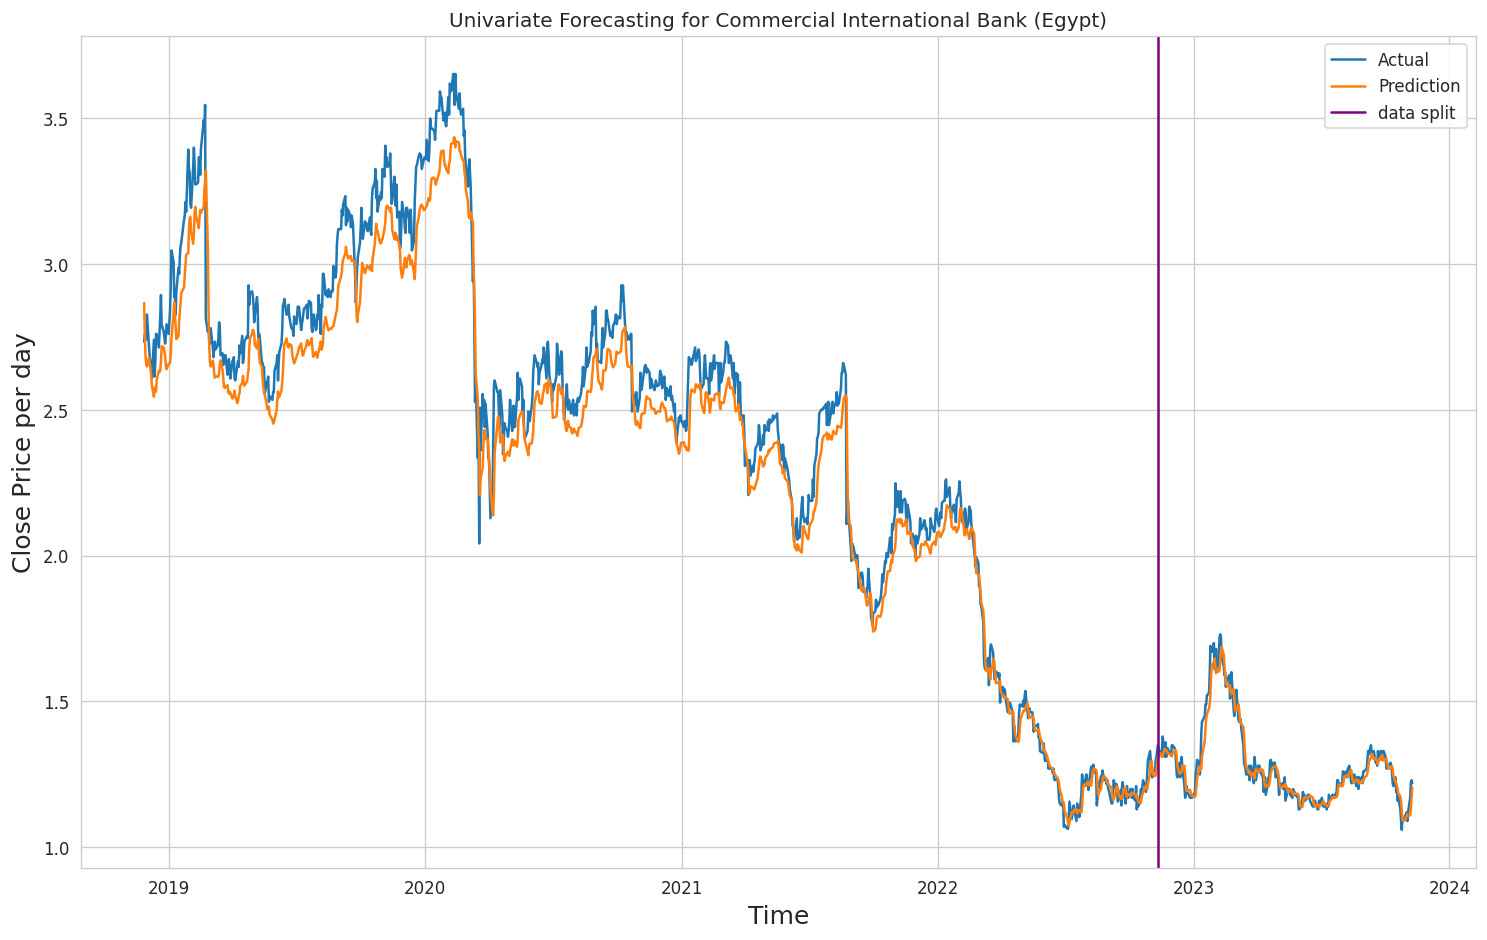

In [82]:
plt.figure(figsize=(15,9))
plt.title("Univariate Forecasting for "+ 'Commercial International Bank (Egypt)')
plt.plot(res5 ,  label="Actual")
plt.plot(output_df ,  label="Prediction")
plt.axvline(x = split_date, color = 'purple', label = 'data split')
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Close Price per day",fontsize = 15)
plt.legend()

train_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_train.reshape(-1,1)), train_pred_inv))
loss = np.sqrt(np.mean(np.square(((scaler.inverse_transform(y_train.reshape(-1,1))-train_pred_inv) /scaler.inverse_transform(y_train.reshape(-1,1)))), axis=0))
print(train_rmse)
print("loss percentage for Training = ","{0:.3%}".format(loss[0]))

test_rmse = math.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)),test_pred_inv))
test_rmse
loss = np.sqrt(np.mean(np.square(((scaler.inverse_transform(y_test.reshape(-1,1))-test_pred_inv) /scaler.inverse_transform(y_test.reshape(-1,1)))), axis=0))
print(test_rmse)
print("loss percentage for Testing = ","{0:.3%}".format(loss[0]))

plt.show()

# ARIMA MODEL

# DATA SPLIT

In [35]:
#split data into train and test set
train_orign, test_orign = ts[3:int(len(ts)*0.8)], ts[int(len(ts)*0.8):]


# **STATIONATY CHECK**


### **DECOMPOSITION**

---


Time series decomposition is the process of dividing a signal into seasonal, trend, residual, and other components that have additive or multiplicative correlations. It  is a useful abstract approach for thinking about time series in general and for better comprehending challenges during time series analysis and forecasting.
Types of decomposition:


1. Additive: is useful When seasonal fluctuation is generally stable across time(Trend + Seasonal + Random)
2. Multiplicative: is useful When seasonal variation grows over time (Trend * Seasonal * Random)



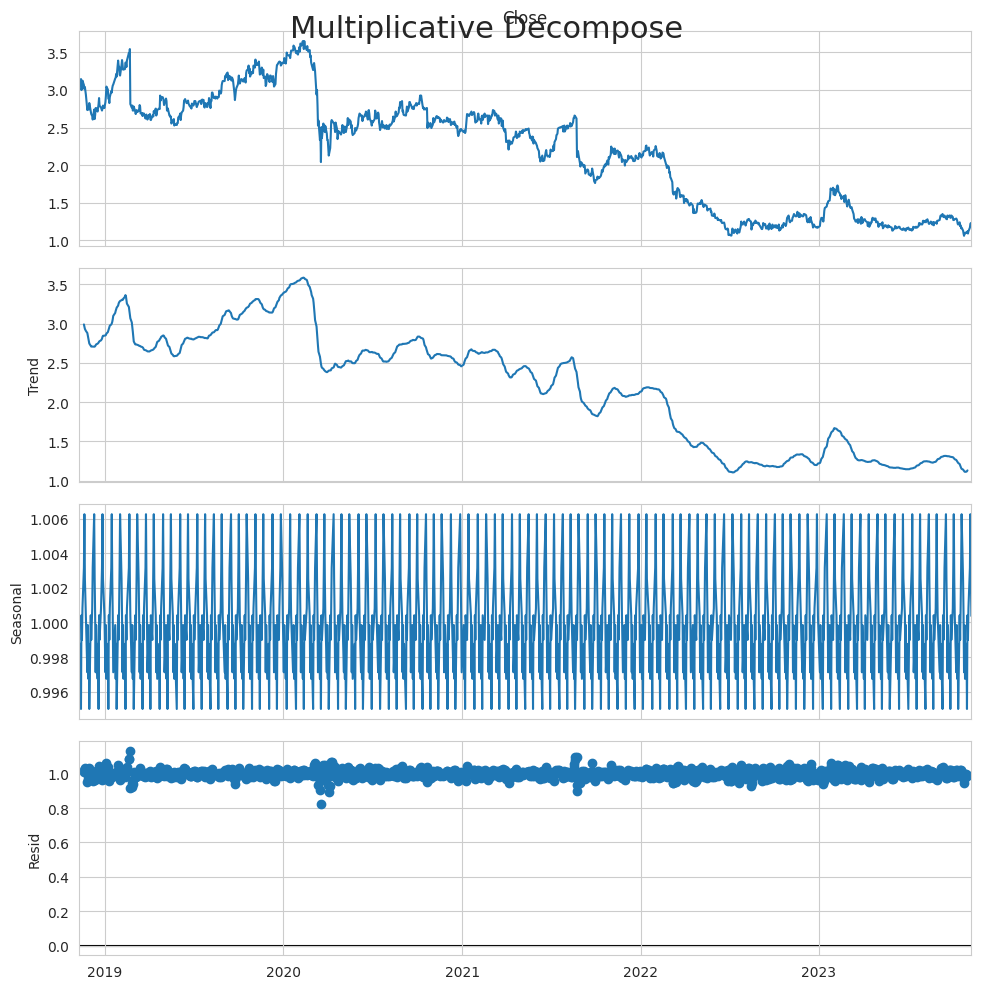

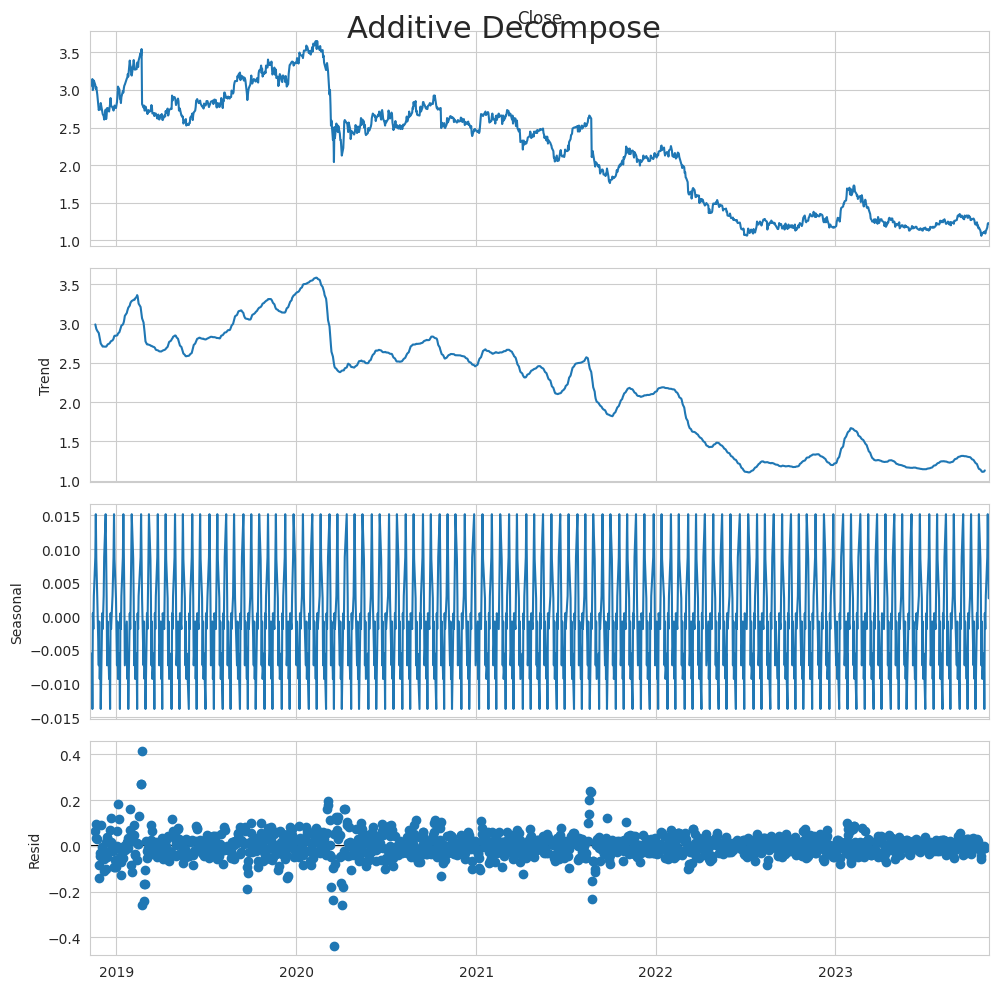

In [36]:
from dateutil.parser import parse
# Multiplicative Decomposition
result_mul = seasonal_decompose(ts, model='multiplicative', period=12)

# Additive Decomposition
result_add = seasonal_decompose(ts, model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

### **DECOMPOSE RESULTS**

In [37]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head(10)

,seas,trend,resid,actual_values
Date,,,,
2018-11-09,0.996738,NaN,NaN,3.045213
2018-11-12,0.998762,NaN,NaN,3.111702
2018-11-13,0.994993,NaN,NaN,3.144947
2018-11-14,1.000415,NaN,NaN,2.998670
2018-11-15,0.998989,NaN,NaN,3.051862
2018-11-16,1.000814,NaN,NaN,3.125000
2018-11-19,1.003160,2.989805,1.021975,3.065160
2018-11-20,1.006263,2.962101,1.010506,3.011968
2018-11-21,1.002526,2.933289,1.033280,3.038564


### **TESTING**

---
A stationary series is one in which the statistical features such as mean, variance, and covariance do not fluctuate with time or are not a function of time. In other words, stationarity in Time Series refers to the absence of a Trend or Seasonal component.



> Method 1 - Rolling Statistics:
 The time series is stationary if the rolling mean and rolling standard deviation remain constant with time.




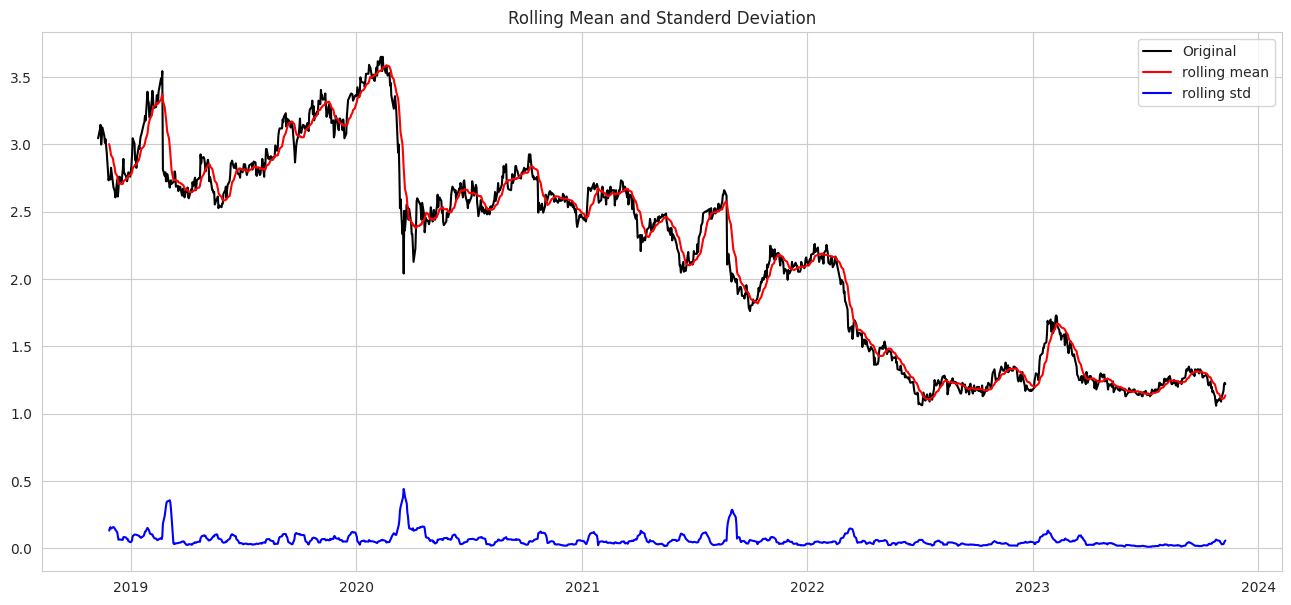

In [38]:
#get the rolling mean
rollmean = ts.rolling(window=12).mean()
#get the rolling standard deviation
rollstd = ts.rolling(window=12).std()
#visualization
plt.figure(figsize=(16,7))
fig=plt.figure(1)
#plot the original time series
org=plt.plot(ts,color='black',label='Original')
#plot the rolling mean and rolling standard deviation
mean=plt.plot(rollmean,color='red',label='rolling mean')
std=plt.plot(rollstd,color='blue',label='rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standerd Deviation')
plt.show()




> Method 2 -ADF: The ADF test belongs to the 'Unit Root Test' group of tests, which is the correct approach for checking the stationarity of a time series. The existence of a unit root indicates that the time series is non-stationary. Furthermore, the number of unit roots in the series is proportional to the number of differencing operations necessary to make the series stationary.



In [39]:
# method 2 -Augmented Dickey-Fuller
#if p-value > 0.05 ---> time series is non-stationary
from statsmodels.tsa.stattools import adfuller
adf_result=adfuller(ts,autolag='AIC')
print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')
print(f'#laps:{adf_result[2]}')
for key , value in adf_result[4].items():
  print("critical values:")
  print(f'{key},{value}')

ADF Statistic:-1.18148916431325
p-value:0.6815074916958986
#laps:1
critical values:
1%,-3.4355671297788666
critical values:
5%,-2.8638438984080117
critical values:
10%,-2.5679966213893057




> Method 3 -Kpss: is a form of Unit root test that looks for series stationarity around a deterministic trend. It is conceptually comparable to the ADF test.



In [40]:
# method 3 -Kwiatkowski-Phillips-Schmidt-Shin
# if p-value < 0.05 --> the series is non-stationary
from statsmodels.tsa.stattools import kpss
print ('Results of KPSS Test:')
kpsstest = kpss(ts, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
  kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Results of KPSS Test:
Test Statistic            5.178099
p-value                   0.010000
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-40-1304d635072c>:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(ts, regression='c', nlags="auto")


Then we conclude from the three methods that the series is non_stationary and need some transformation to be applied in ARIMA model

## **TRANSFORMATION**

---
This process is necessary to make series stationary. It also increases data quality and safeguards programmes against possible stumbling blocks such as null values, unexpected duplicates, erroneous indexing, and incompatible formats.




> Method 1 -log then diffrence: The log-diffrence transformation is frequently used to turn nonstationary time series with regard to the innovation variance into stationary time series.



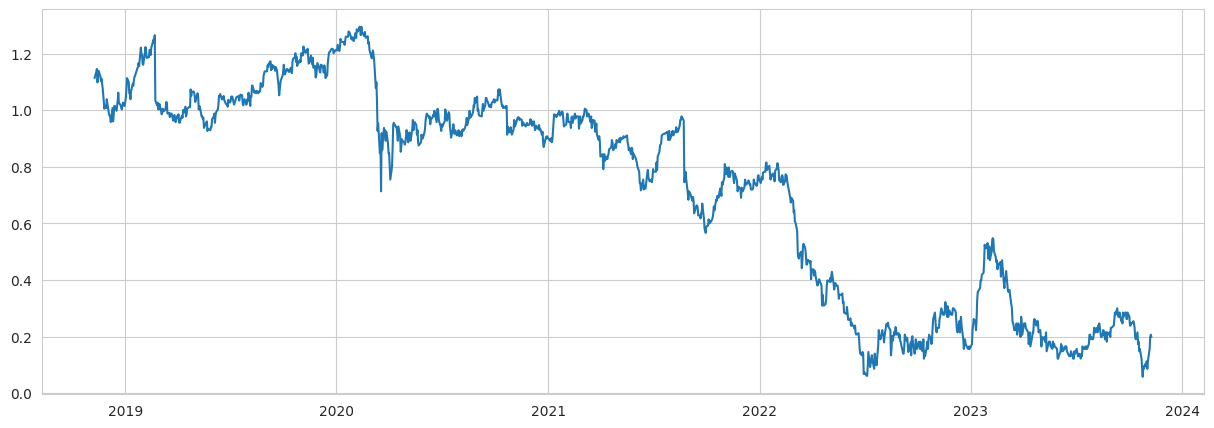

In [41]:
#Log Transformation
plt.figure(figsize=(15,5))
fig = plt.figure(1)
import numpy as np
ts_log = np.log(ts)
plt.plot(ts_log)

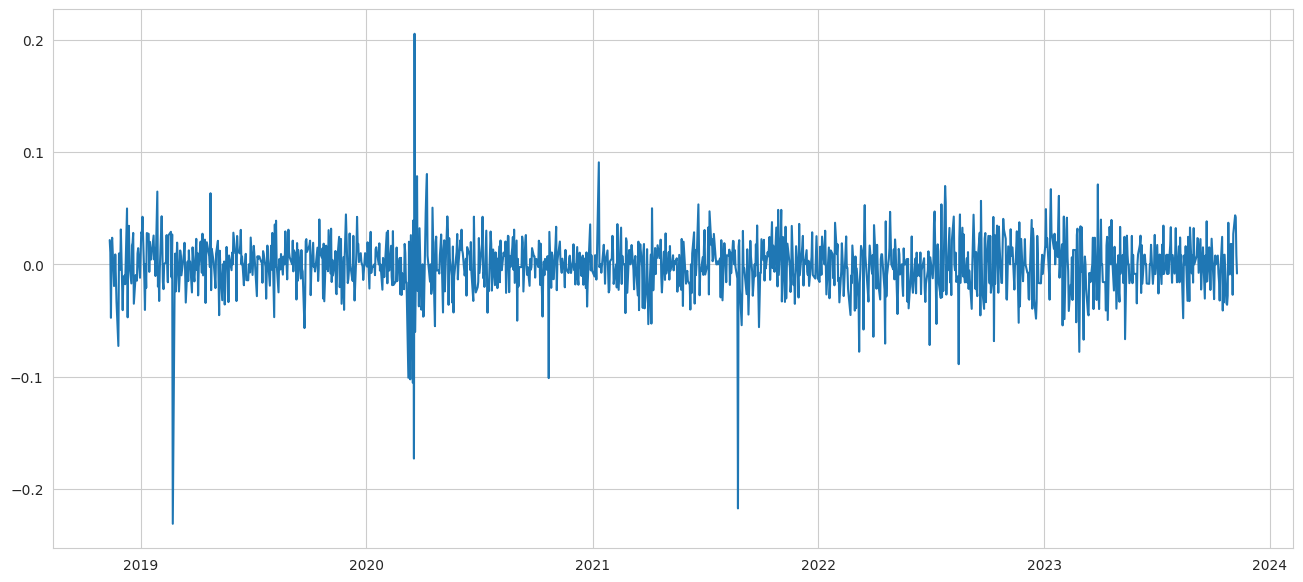

In [42]:
#Diffrencing Log Transformation
plt.figure(figsize=(16,7))
fig=plt.figure(1)
ts_log_diff=ts_log - ts_log.shift()
ts_log_diff=ts_log_diff[1:]
ts_log_diff.head()
plt.plot(ts_log_diff)





> First method checking by Rolling Statistics



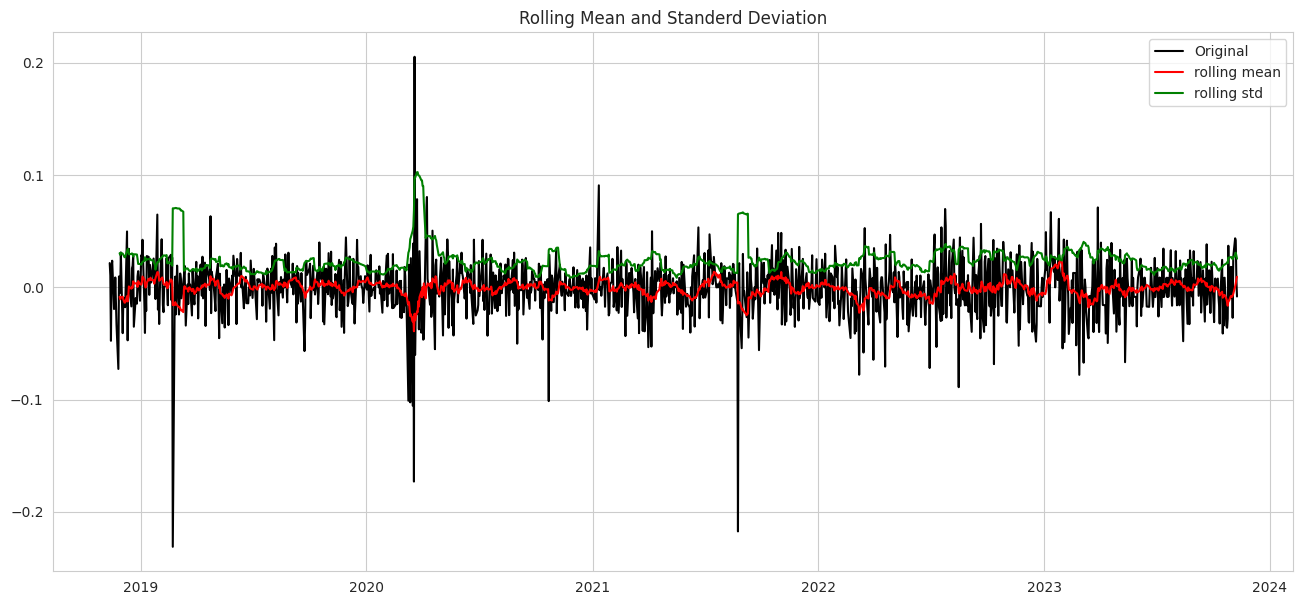

In [43]:
# Again testing if data is stationary
# method 2 - Rolling Statistics
rollmean = ts_log_diff.rolling(window=12).mean()
rollstd =  ts_log_diff.rolling(window=12).std()
plt.figure(figsize=(16,7))
fig=plt.figure(1)
org=plt.plot(ts_log_diff,color='black',label='Original')
mean=plt.plot(rollmean,color='red',label='rolling mean')
std=plt.plot(rollstd,color='green',label='rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standerd Deviation')
plt.show()


The rolling mean and standard deviation become constant relatively



> First method checking by ADF



In [44]:
#steationay check
# method 2 -ADF
from statsmodels.tsa.stattools import adfuller
adf_result=adfuller(ts_log_diff,autolag='AIC')
print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')
print(f'#laps:{adf_result[2]}')
for key , value in adf_result[4].items():
  print("critical values:")
  print(f'{key},{value}')

ADF Statistic:-42.08465691648553
p-value:0.0
#laps:0
critical values:
1%,-3.4355671297788666
critical values:
5%,-2.8638438984080117
critical values:
10%,-2.5679966213893057


The p-value changed from 0.8 to 0 (<0.05)



> Method 2 -Detrended: Another method to make the series stationary is to eliminate the trend.


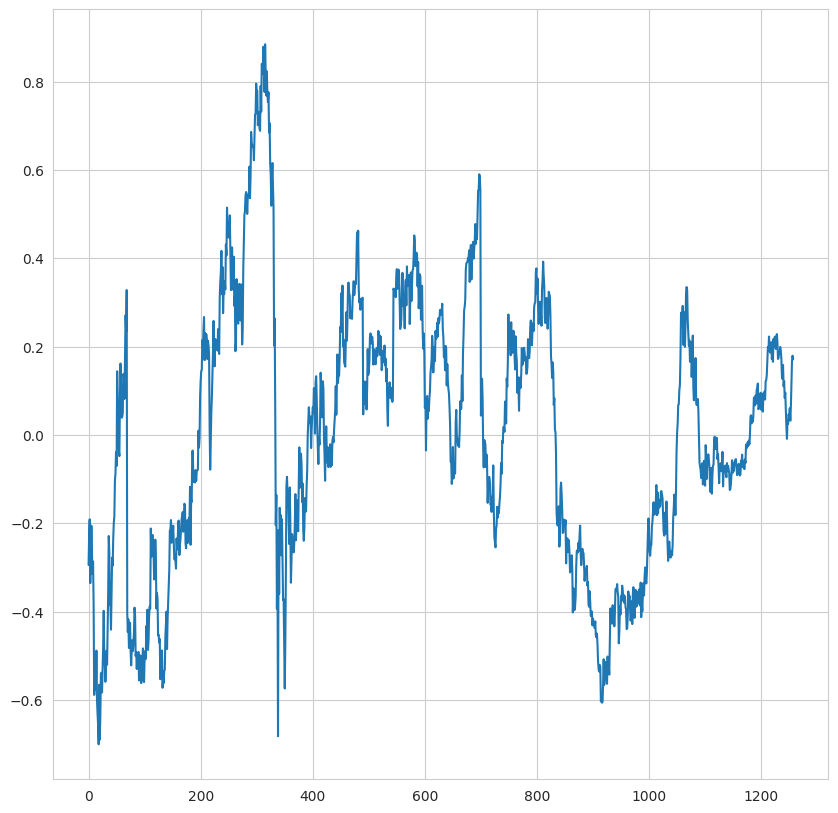

In [45]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(ts.values)
plt.plot(detrended)

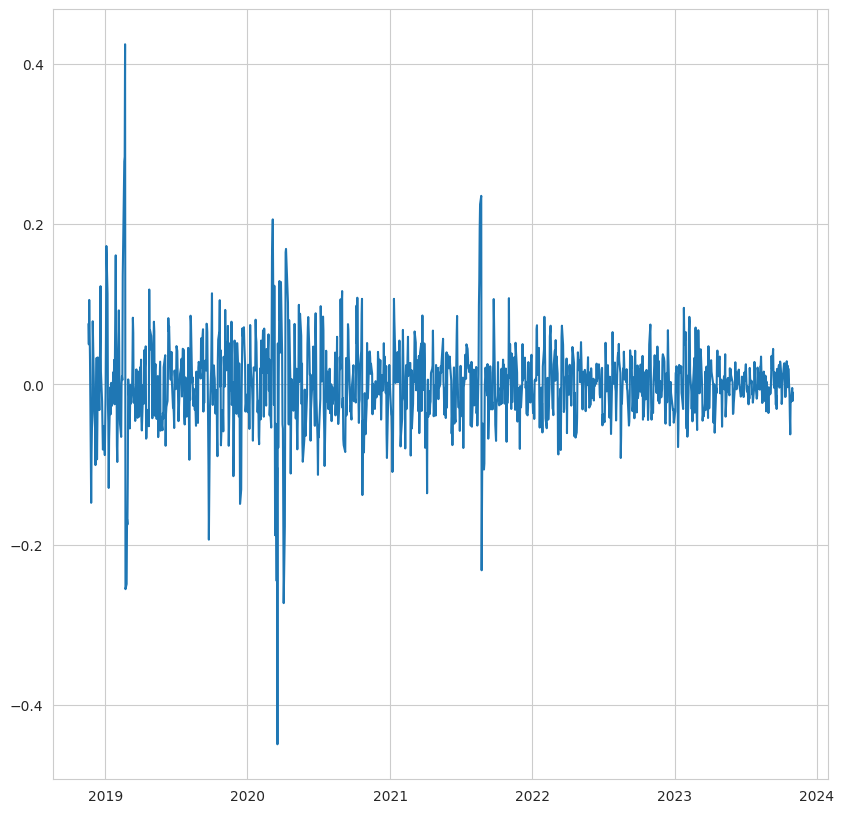

In [46]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(ts, model='multiplicative', period=12)
detrended = ts.values - result_mul.trend
plt.plot(detrended)



> Second method checking by ADF



In [47]:
from statsmodels.tsa.stattools import adfuller
detrended.fillna(999, inplace=True)
adf_result=adfuller(detrended,autolag='AIC')
print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')
for key , value in adf_result[4].items():
  print("critical values:")
  print(f'{key},{value}')

ADF Statistic:-7.766005119507705
p-value:9.18457095410469e-12
critical values:
1%,-3.4355629707955395
critical values:
5%,-2.863842063387667
critical values:
10%,-2.567995644141416


After apply the second method the p-value become 8.9e-12 which is <0.05 but the best value for p is 0, so we will use the first method.

## **MODELING**

### **ORDER DETERMINING**

---

It is important to determine the order of the ARIMA model to fit and predict the model. This step includes determining the values of p,d, and q. The term p represents the number of lags. The term q represents the number of lagged errors. while term d represents the number of differences required to make the time series stationary.

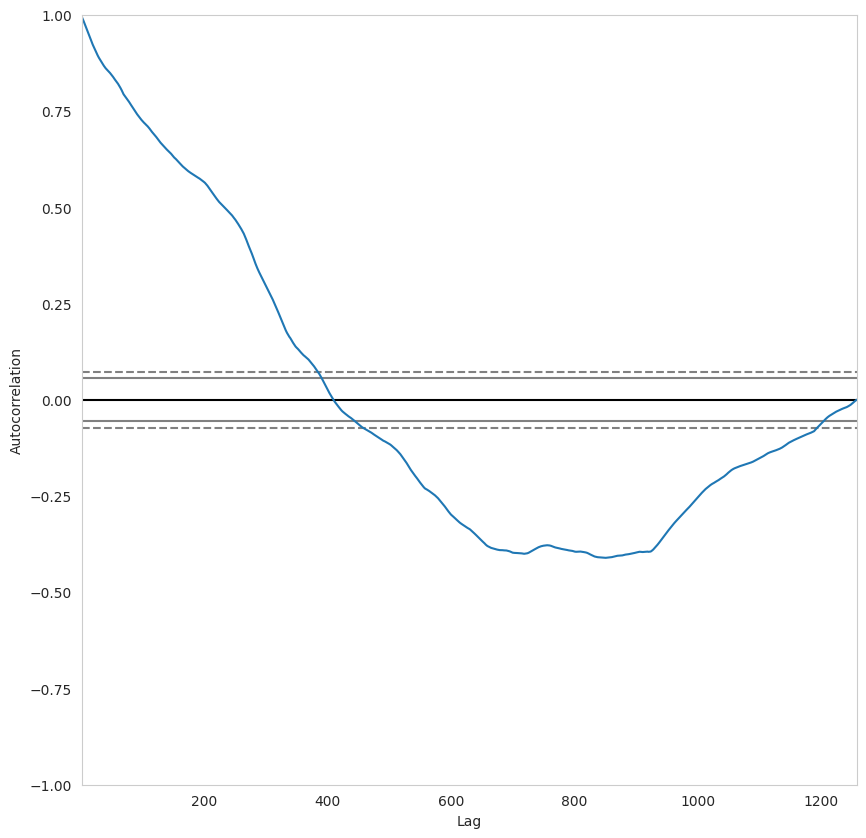

In [48]:
#plot the autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)
plt.show()



> Determine d-value



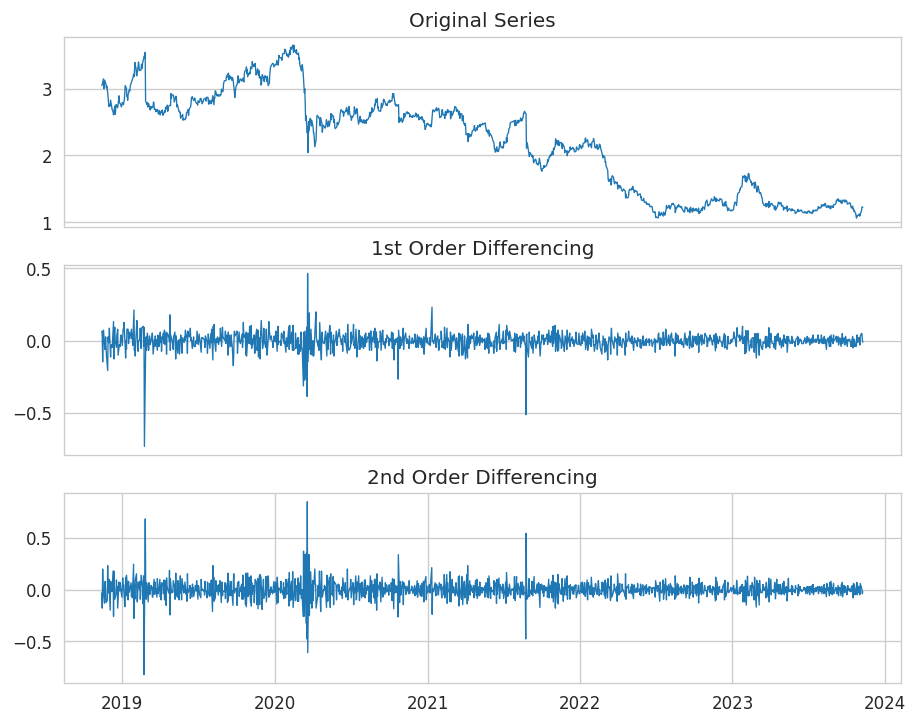

In [49]:
#determine d-value
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
#apply differencing
ts_d=ts.diff()
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(ts,linewidth=0.8); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(ts_d,linewidth=0.8); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(ts_d.diff(),linewidth=0.8); ax3.set_title('2nd Order Differencing')
plt.show()
#or instead of using this method we can say that d=1 because we differenced our data once to make it stationar

The second order differencing contains more noise, so we will choose the first order in our model (d=1)



> Check stationarity for diffrencing by ADF



In [50]:
from statsmodels.tsa.stattools import adfuller
#fill nan values
ts_d.fillna(999, inplace=True)
#apply the test
adf_result=adfuller(ts_d,autolag='AIC')
print(f'ADF Statistic:{adf_result[0]}')
print(f'p-value:{adf_result[1]}')
for key , value in adf_result[4].items():
  print("critical values:")
  print(f'{key},{value}')

ADF Statistic:-16670.88165271784
p-value:0.0
critical values:
1%,-3.4355629707955395
critical values:
5%,-2.863842063387667
critical values:
10%,-2.567995644141416




> Determine p-value and q-value



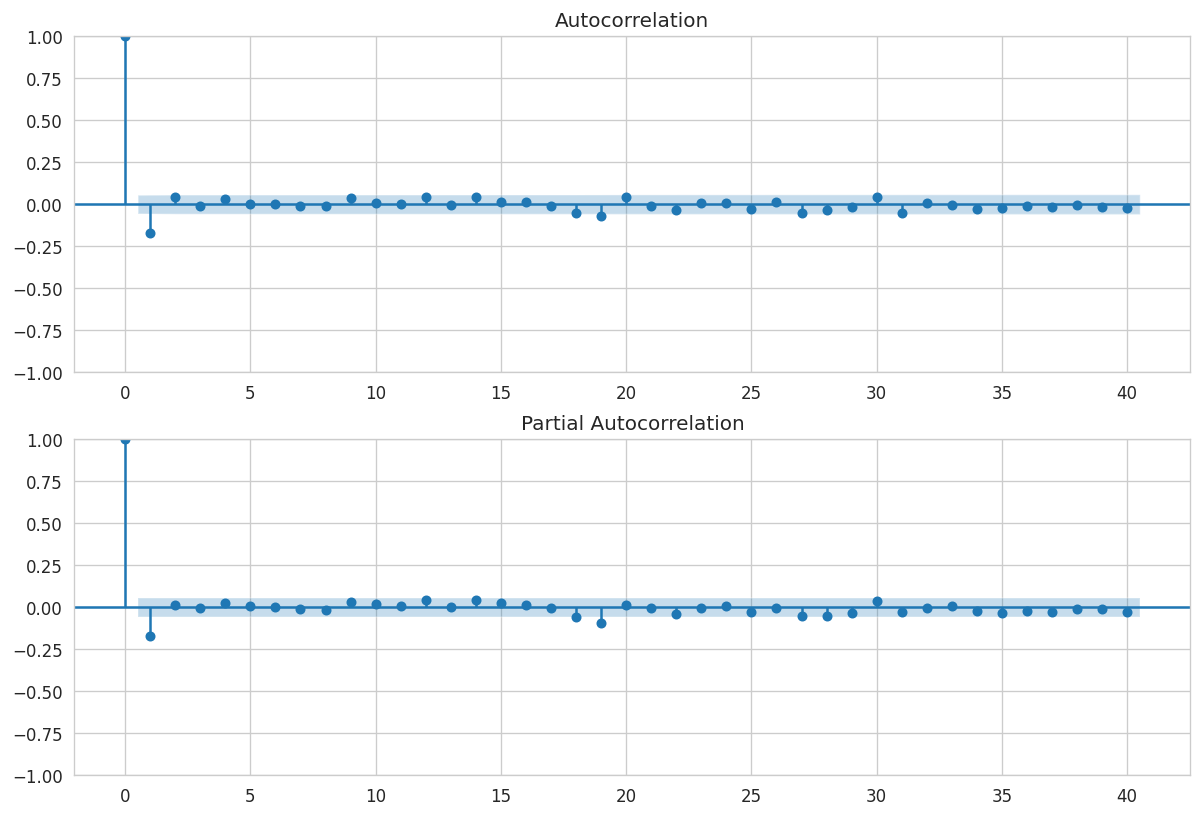

In [51]:
#determine p-value and q
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
#plot ACF and PACF once to determine the p and q values
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.diff().dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.diff().dropna(),lags=40,ax=ax2)



> Determine p-value and q-value by Auto ARIMA



In [52]:
#the model is designed to work with non-stationary data
import pmdarima as pm
def arima_model (timeseries):
      automodel=pm.auto_arima(timeseries,start_p=0,start_q=0,max_p=3,max_q=3,trace=True)
      return automodel
arima_model(train_orign)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2637.518, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2665.312, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2663.140, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2638.832, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2664.058, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2664.215, Time=1.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2662.433, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-2666.327, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-2665.133, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-2665.280, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-2664.124, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-2663.482, Time=0.32 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.997 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

If we model AUTO ARIMA to the non-stationary time series, we will use the order (0,1,1)



> Determine p-value and q-value by cross validation



In [53]:
#cross validation
from pmdarima import model_selection
model1 = pm.ARIMA(order=(1, 0, 0))
model2 = pm.ARIMA(order=(1, 1, 0))
model3 = pm.ARIMA(order=(0, 1, 1),suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=100, step=24, h=1)
#calculate the scores
model1_cv_scores = model_selection.cross_val_score(model1, train_orign, scoring='smape', cv=cv, verbose=2)
model2_cv_scores = model_selection.cross_val_score(model2, train_orign, scoring='smape', cv=cv, verbose=2)
model3_cv_scores = model_selection.cross_val_score(model2, train_orign, scoring='smape', cv=cv, verbose=2)
print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))
print("Model 3 CV scores: {}".format(model3_cv_scores.tolist()))
# Pick based on which has a lower mean error rate
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
m3_average_error = np.average(model3_cv_scores)
errors = [m1_average_error, m2_average_error,m3_average_error]
models = [model1, model2,model3]
# print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average SMAPE: {} (model{})".format(errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p

[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/stat

[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=13 .........................................................
[CV] fold=14 .........................................................
[CV] fold=15 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=19 .........................................................
[CV] fold=20 .........................................................
[CV] fold=21 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................
[CV] fold=25 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=30 .........................................................
[CV] fold=31 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=32 .........................................................
[CV] fold=33 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=34 .........................................................
[CV] fold=35 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=36 .........................................................
[CV] fold=37 .........................................................
[CV] fold=0 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................
[CV] fold=24 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................
[CV] fold=29 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/stat

[CV] fold=30 .........................................................
[CV] fold=31 .........................................................
[CV] fold=32 .........................................................
[CV] fold=33 .........................................................
[CV] fold=34 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/p

[CV] fold=35 .........................................................
[CV] fold=36 .........................................................
[CV] fold=37 .........................................................
[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] fold=14 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=15 .........................................................
[CV] fold=16 .........................................................
[CV] fold=17 .........................................................
[CV] fold=18 .........................................................
[CV] fold=19 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=20 .........................................................
[CV] fold=21 .........................................................
[CV] fold=22 .........................................................
[CV] fold=23 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=24 .........................................................
[CV] fold=25 .........................................................
[CV] fold=26 .........................................................
[CV] fold=27 .........................................................
[CV] fold=28 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/stat

[CV] fold=29 .........................................................
[CV] fold=30 .........................................................


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

[CV] fold=31 .........................................................
[CV] fold=32 .........................................................
[CV] fold=33 .........................................................
[CV] fold=34 .........................................................
[CV] fold=35 .........................................................
[CV] fold=36 .........................................................
[CV] fold=37 .........................................................
Model 1 CV scores: [2.027811970280945, 0.4004843045044271, 0.8047434233011016, 1.8009408433590366, 3.6529204899135364, 2.4004515106304027, 3.521045405890083, 1.3231865808458965, 0.3738284211371009, 1.1526152806769914, 0.6108857397882176, 0.2848805778320665, 2.7397146098781735, 1.387170396814008, 0.9561205671961106, 3.3720301143282425, 0.17647523320921893, 0.7545097176249174, 2.7881726012959245, 2.3316890560900223, 1.489568086226027, 1.9693908933502258, 0.35207115090606583, 5.048828429073671, 0.6087

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-p

If we model ARIMA to the stationary time series, we will use the order (1,1,0)

### **STATIONARY DATA SPLIT**

---
Split data after make it stationary is important to fit the ARIMA model and predict. The data is splitted into 80% training set and 20% test set.


In [54]:
#split data into train and training set
ts_log_diff=ts_log_diff.dropna()
train_diff, test_diff = ts_log_diff[3:int(len(ts_log_diff)*0.8)], ts_log_diff[int(len(ts_log_diff)*0.8):]

### **MODEL TRAINING**

---

This step takes the order determined before and time series transformed before to stationary in order to train the model and make prediction.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1257
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2515.517
Date:                Thu, 09 Nov 2023   AIC                          -5027.035
Time:                        20:23:35   BIC                          -5016.763
Sample:                             0   HQIC                         -5023.174
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5826      0.012    -48.051      0.000      -0.606      -0.559
sigma2         0.0011   2.11e-05     50.416      0.000       0.001       0.001
Ljung-Box (L1) (Q):                  58.08   Jarque-

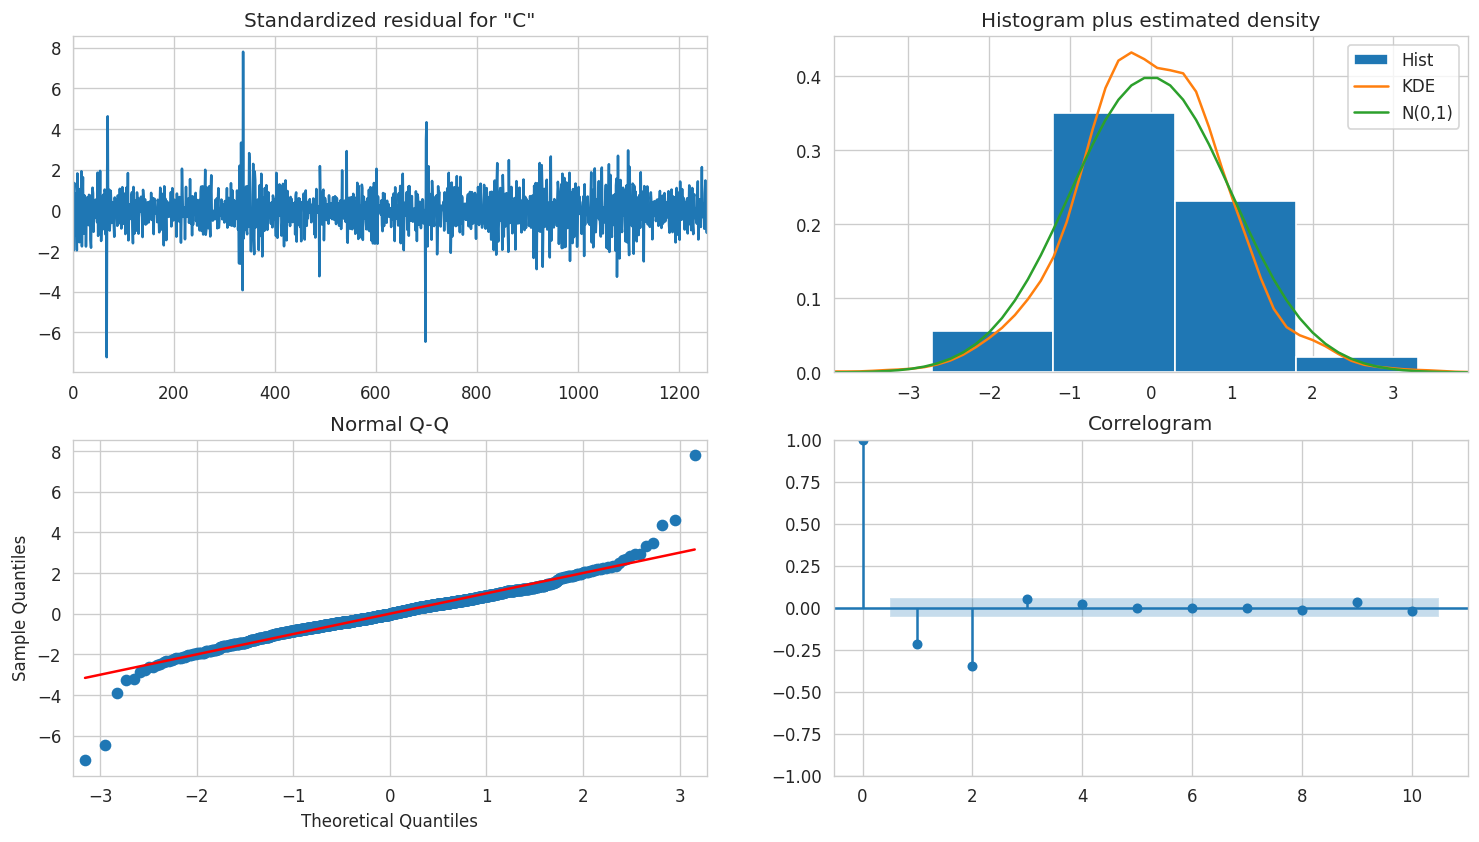

In [55]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
#fit the model with the stationary time series and order (1,1,0)
model = ARIMA(ts_log_diff, order=(1,1,0))
fitted = model.fit()
#get the summary of the model
print(fitted.summary())
fitted.plot_diagnostics(figsize=(15,8))
plt.show()


1. Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

2. Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

3. Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

4. Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot.

### **RESIDUAL ERRORS**

---

Forecasting residual errors on a time series give another piece of information that we can predict. Residual errors constitute a time series with a temporal structure. This structure's simple autoregression model may be used to predict prediction error, which can then be used to correct forecasts. This model is known as a moving average model, which is similar to but not the same as moving average smoothing.

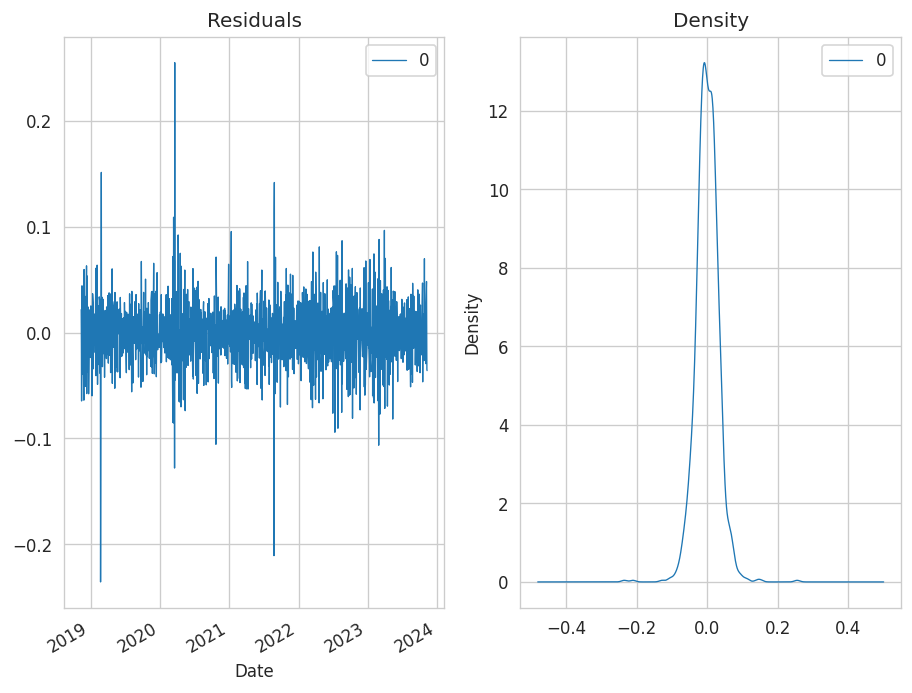

In [56]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0],linewidth=0.8)
residuals.plot(kind='kde', title='Density', ax=ax[1],linewidth=0.8)
plt.show()

## **PREDICTION**

---

In this step, the model is being trained and ready for prediction.

In [57]:
predictions = fitted.predict()
print(predictions)

Date
2018-11-12    0.000000
2018-11-13    0.021599
2018-11-14    0.017019
2018-11-15   -0.013691
2018-11-16   -0.020407
                ...   
2023-11-03   -0.000837
2023-11-06   -0.004483
2023-11-07    0.034049
2023-11-08    0.042912
2023-11-09    0.027786
Name: predicted_mean, Length: 1257, dtype: float64


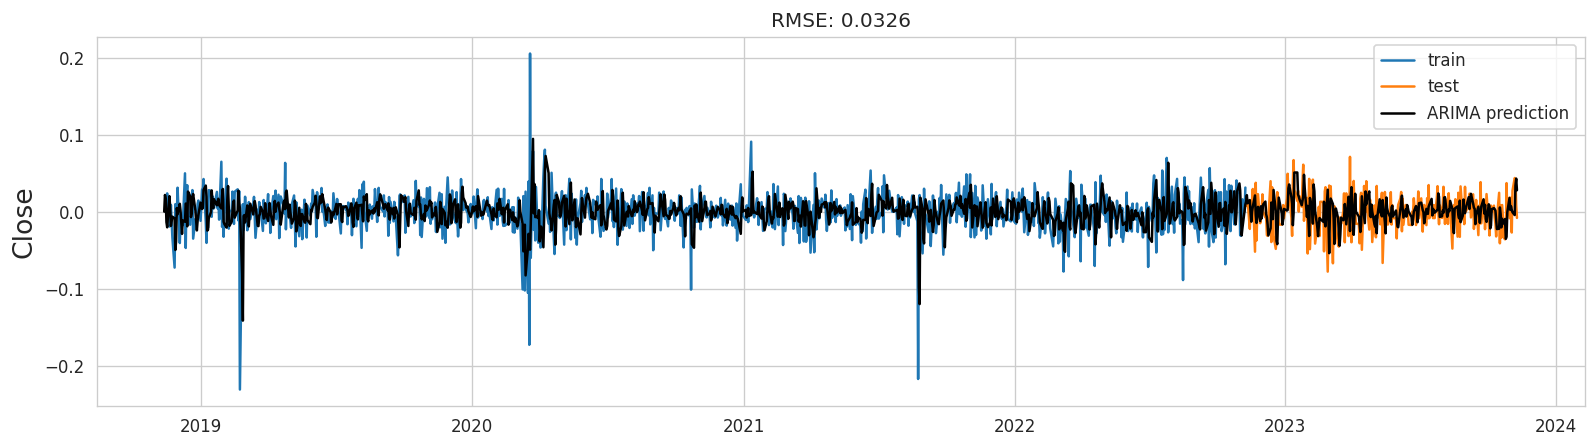

In [58]:
#plot the original stationary time series vs the predicted one with the model
plt.figure(figsize=(16,4))

plt.plot(train_diff, label="train")
plt.plot(test_diff, label="test")
plt.plot(predictions, label="ARIMA prediction",color='black')
plt.ylabel('Close', fontsize=16)
#calculate RMSE error
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions-ts_log_diff)**2)/len(ts_log_diff)))
plt.legend()

In [59]:
#calculate the exponential of the prediction to cancel the log transformation
predictionsadjusted=np.exp(predictions)
predictionsadjusted

Date
2018-11-12    1.000000
2018-11-13    1.021834
2018-11-14    1.017165
2018-11-15    0.986403
2018-11-16    0.979800
                ...   
2023-11-03    0.999163
2023-11-06    0.995527
2023-11-07    1.034635
2023-11-08    1.043846
2023-11-09    1.028176
Name: predicted_mean, Length: 1257, dtype: float64

In [60]:
#transform the fitted model to time series
ARIMA_prediction=pd.Series(fitted.fittedvalues,copy=True)

In [61]:
#ARIMA_diff_pred=pd.Series(fitted.fittedvalues,copy=True) # converting the fitted values of the results into series
ARIMA_pred_cumsum=ARIMA_prediction.cumsum() # calculating the cumulative sum
ARIMA_log_pred=pd.Series(ts_log.iloc[0],index=ts_log.index)
ARIMA_log_pred=ARIMA_log_pred.add(ARIMA_pred_cumsum,fill_value=0) # adding the cumulative sum to the differenced data to cancel out the differencing effect

Text(0.5, 1.0, 'RMSE: 0.0714')

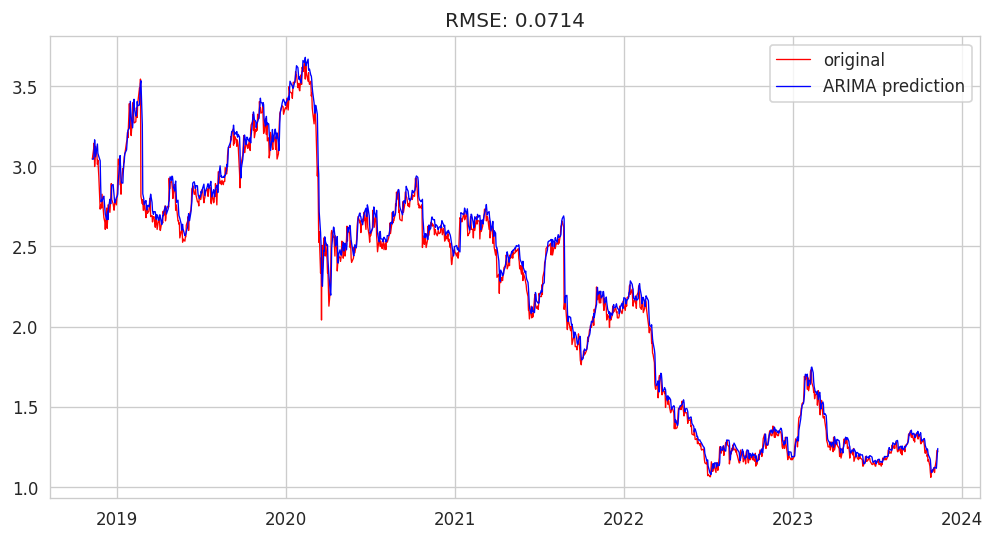

In [62]:
#plot the original time series vs the predicted one with the model
plt.figure(figsize=(10,5))
predictions_ARIMA = np.exp(ARIMA_log_pred)
plt.plot(ts,color='red',linewidth=0.8)
plt.plot(predictions_ARIMA,color='blue',linewidth=0.8)
plt.legend(labels=['original','ARIMA prediction','RMSE'])
#calculate RMSE error
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))



> Calculate the loss percentage for Training and testing



In [63]:
#split the predictions into train and test set
train_pred, test_pred = predictions_ARIMA[3:int(len(predictions_ARIMA)*0.8)], predictions_ARIMA[int(len(predictions_ARIMA)*0.8):]

In [64]:
#calculate the losses
train_loss = (np.sqrt(np.mean(np.square((((train_orign)-train_pred) /(train_orign)))))*100)
test_loss = (np.sqrt(np.mean(np.square((((test_orign)-test_pred) /(test_orign)))))*100)

In [65]:
#print the answers
print("loss percentage for Training = ",(train_loss),"%")
print("loss percentage for Testing = ",(test_loss),"%")

loss percentage for Training =  3.269151101431139 %
loss percentage for Testing =  3.0509363680404307 %


## **MODEL EVALUATION**



---


The final step is evaluation to make sure the the model work as expected and
with the minimum errors. There are many types of error to evaluate the performance of the model:


1. Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors).
2. The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics.
3. The mean percentage error (MPE) is the computed average of percentage errors by which forecasts of a model differ from actual values of the quantity being forecast.
4. The mean squared error (MSE) or mean squared deviation (MSD) of an estimator measures the average of the squares of the errors that is, the average squared difference between the estimated values and the actual value.
5. The mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon.

In [66]:
#### Calculate the metrics RMSE, MAPE, MPE, MSE and MAE ####
def calculate_rmse(ts, predictions_ARIMA):
    rmse = np.sqrt(np.mean((ts-predictions_ARIMA)**2))
    print("rmse= ",rmse)
def calculate_mape(ts, predictions_ARIMA):
    predictions_ARIMA, ts = np.array(predictions_ARIMA), np.array(ts)
    mape = np.mean(np.abs((ts-predictions_ARIMA) / np.abs(ts)))
    print("mape= ",mape)
def calculate_mpe(ts, predictions_ARIMA):
    predictions_ARIMA, ts = np.array(predictions_ARIMA), np.array(ts)
    mpe = np.mean((ts-predictions_ARIMA) / ts)
    print("mpe= ",mpe)
def calculate_mse(ts, predictions_ARIMA):
    predictions_ARIMA, ts = np.array(predictions_ARIMA), np.array(ts)
    mse = np.square(np.subtract(ts,predictions_ARIMA)).mean()
    print("mse= ",mse)
def calculate_mae(ts, predictions_ARIMA):
    predictions_ARIMA, ts = np.array(predictions_ARIMA), np.array(ts)
    mae = np.mean(np.abs(ts-predictions_ARIMA))
    print("mae= ",mae)


> For LSTM model


In [67]:
calculate_mae(res4, output_df)

mae=  0.7954506745501138


In [68]:
calculate_mape(res4, output_df)

mape=  0.4185028764992454


In [69]:
calculate_mse(res4, output_df)

mse=  0.976874725256078


In [70]:
calculate_mpe(res4, output_df)


mpe=  -0.09800927923615035




> For ARIMA model



In [71]:
calculate_rmse(ts, predictions_ARIMA)

rmse=  0.07135820516732837


In [72]:
calculate_mae(ts, predictions_ARIMA)

mae=  0.04887934098936225


In [73]:
calculate_mape(ts, predictions_ARIMA)

mape=  0.023065262675961713


In [74]:
calculate_mse(ts, predictions_ARIMA)

mse=  0.0050919934447025295


In [75]:
calculate_mpe(ts, predictions_ARIMA)

mpe=  -0.0142068943623699
